In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import *

from ipywidgets import IntProgress
from IPython.display import display

In [17]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [18]:
import matplotlib
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16

sns.set_style("white")

In [19]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [20]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

In [21]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

# Load Pulsar Data

In [23]:
# Takes about 30 s
start = time.time()

vt_all = []

f = IntProgress(min=0, max=81) # instantiate the bar
display(f) # display the bar

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))
    f.value +=1

end = time.time()
print(end - start, "s")

IntProgress(value=0, max=81)

26.522466897964478 s


# SSE

## Read Model Velocities

In [25]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D_SSE = []
NS_KICKS_2D_SSE = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=len(ns_kicks) * len(sigmas)) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D_SSE.append(v_3d)
        NS_KICKS_2D_SSE.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=45)

93.58028244972229 s


# Read Likelihood Data

In [26]:
p_models_sse = []
columns_sse = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"

        all_likelihoods = np.loadtxt(fname)
        p_models_sse.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models_sse = p_models_sse/np.sum(p_models_sse)

In [27]:
# Identify the 5 most likely models
M = sorted(zip(p_models_sse), reverse=True)[:5]
MAX_INDICES_SSE = np.where(p_models_sse==M)[1]
print(MAX_INDICES_SSE)

[27 22 32 28 33]


In [28]:
PLOT_DATA = [vt_all, NS_KICKS_2D_SSE, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# KS Test (scipy)

In [32]:
N_TESTS = 500

ks_stats_sse = np.zeros((len(MAX_INDICES_SSE), N_TESTS))
p_values_sse = np.zeros((len(MAX_INDICES_SSE), N_TESTS))

In [33]:
print("Performing KS-Test")
start = time.time()
f = IntProgress(min=0, max=len(MAX_INDICES_SSE)*N_TESTS) # instantiate the bar
display(f) # display the bar

for i in range(len(MAX_INDICES_SSE)):
    model_data_sse = NS_KICKS_2D_SSE[MAX_INDICES_SSE[i]]
    for n_test in range(N_TESTS):
        f.value += 1 
        # Draw posterior sample
        vt_draw = np.zeros(len(vt_all))        
        for j in range(len(vt_draw)):
            vt_draw[j] = vt_all[j][np.random.randint(len(vt_all[j]))]
            
        ks_stats_sse[i, n_test], p_values_sse[i, n_test] = ks_2samp(vt_draw, model_data_sse)
                             
end = time.time()
print(f"KS-Test completed in {end - start:2f} s")

Performing KS-Test


IntProgress(value=0, max=2500)

KS-Test completed in 99.489860 s


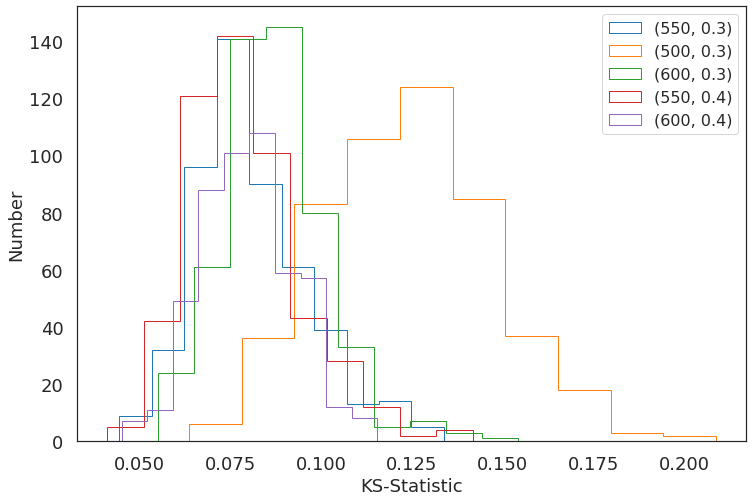

In [34]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
for i in range(len(MAX_INDICES_SSE)):
    plt.hist(ks_stats_sse[i], histtype='step', label=f'({NS_KICK_MULT[MAX_INDICES_SSE[i]]}, {SIGMAS[MAX_INDICES_SSE[i]]})')

layoutAxes(ax=ax, nameX='KS-Statistic',\
                   nameY='Number')
plt.legend(fontsize=16)
plt.show()

## Results

In [35]:
for i in range(len(MAX_INDICES_SSE)):    
    print(f"Sc KS Test for {NS_KICK_MULT[MAX_INDICES_SSE[i]]}, {SIGMAS[MAX_INDICES_SSE[i]]}:",\
          f" ks_stat = {np.mean(ks_stats_sse[i]):.3f} +/- {np.std(ks_stats_sse[i]):.3f}, ", \
          f"p_value = {np.mean(p_values_sse[i]):.3f}+/-{np.std(p_values_sse[i]):.3f}")

Sc KS Test for 550, 0.3:  ks_stat = 0.081 +/- 0.016,  p_value = 0.664+/-0.201
Sc KS Test for 500, 0.3:  ks_stat = 0.124 +/- 0.023,  p_value = 0.214+/-0.168
Sc KS Test for 600, 0.3:  ks_stat = 0.087 +/- 0.014,  p_value = 0.576+/-0.183
Sc KS Test for 550, 0.4:  ks_stat = 0.079 +/- 0.015,  p_value = 0.691+/-0.197
Sc KS Test for 600, 0.4:  ks_stat = 0.080 +/- 0.013,  p_value = 0.672+/-0.170


# BSE

## Read Model Velocities

In [36]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D_BSE = []
NS_KICKS_2D_BSE = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=len(ns_kicks)*len(sigmas)) # instantiate the bar
display(f)

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities_bse/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D_BSE.append(v_3d)
        NS_KICKS_2D_BSE.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

88.51133394241333 s


# Read Likelihood Data

In [39]:
p_models_bse = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods_bse/vns_{ns_kick}_sigma_{sigma}"

        all_likelihoods = np.loadtxt(fname)
        p_models_bse.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models_bse = p_models_bse/np.sum(p_models_bse)

In [41]:
# Identify the 5 most likely models
M = sorted(zip(p_models_bse), reverse=True)[:5]
MAX_INDICES_BSE = np.where(p_models_bse==M)[1]
print(MAX_INDICES_BSE)

[27 32 22 26 31]


In [42]:
PLOT_DATA_BSE = [vt_all, NS_KICKS_2D_BSE, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# KS Test (scipy)

In [43]:
N_TESTS = 500

ks_stats_bse = np.zeros((len(MAX_INDICES_BSE), N_TESTS))
p_values_bse = np.zeros((len(MAX_INDICES_BSE), N_TESTS))

In [44]:
print("Performing KS-Test")
start = time.time()
f = IntProgress(min=0, max=len(MAX_INDICES_BSE)*N_TESTS) # instantiate the bar
display(f) # display the bar

for i in range(len(MAX_INDICES_BSE)):
    model_data_bse = NS_KICKS_2D_BSE[MAX_INDICES_BSE[i]]
    for n_test in range(N_TESTS):
        f.value += 1 
        # Draw posterior sample
        vt_draw = np.zeros(len(vt_all))        
        for j in range(len(vt_draw)):
            vt_draw[j] = vt_all[j][np.random.randint(len(vt_all[j]))]
            
        ks_stats_bse[i, n_test], p_values_bse[i, n_test] = ks_2samp(vt_draw, model_data_bse)
                             
end = time.time()
print(f"KS-Test completed in {end - start:2f} s")

Performing KS-Test


IntProgress(value=0, max=2500)

KS-Test completed in 93.349076 s


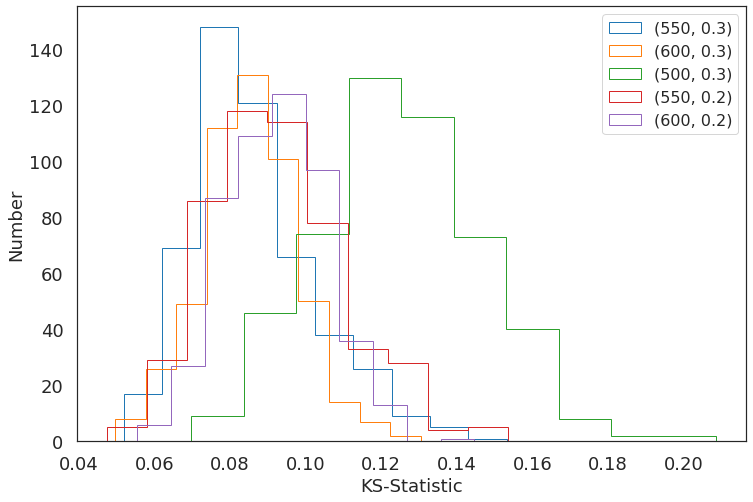

In [45]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
for i in range(len(MAX_INDICES_BSE)):
    plt.hist(ks_stats_bse[i], histtype='step', label=f'({NS_KICK_MULT[MAX_INDICES_BSE[i]]}, {SIGMAS[MAX_INDICES_BSE[i]]})')

layoutAxes(ax=ax, nameX='KS-Statistic',\
                   nameY='Number')
plt.legend(fontsize=16)
plt.show()

## Results

In [46]:
for i in range(len(MAX_INDICES_BSE)):    
    print(f"Sc KS Test for {NS_KICK_MULT[MAX_INDICES_BSE[i]]}, {SIGMAS[MAX_INDICES_BSE[i]]}:",\
          f" ks_stat = {np.mean(ks_stats_bse[i]):.3f} +/- {np.std(ks_stats_bse[i]):.3f}, ", \
          f"p_value = {np.mean(p_values_bse[i]):.3f}+/-{np.std(p_values_bse[i]):.3f}")

Sc KS Test for 550, 0.3:  ks_stat = 0.086 +/- 0.016,  p_value = 0.602+/-0.208
Sc KS Test for 600, 0.3:  ks_stat = 0.085 +/- 0.013,  p_value = 0.598+/-0.170
Sc KS Test for 500, 0.3:  ks_stat = 0.125 +/- 0.022,  p_value = 0.203+/-0.156
Sc KS Test for 550, 0.2:  ks_stat = 0.092 +/- 0.018,  p_value = 0.516+/-0.212
Sc KS Test for 600, 0.2:  ks_stat = 0.093 +/- 0.013,  p_value = 0.504+/-0.172
